In [1]:
# !unzip double_mnist.zip -d /content/double_mnist


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

unzip_dir = ''
# List the contents of the extracted 'double_mnist' folder
os.listdir(os.path.join(unzip_dir, 'double_mnist'))


['val', '.ipynb_checkpoints', 'test', 'train']

In [3]:
class MultiMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Custom Dataset for loading MultiMNIST images for the given task.
        root_dir: Directory with subfolders containing images.
        transform: Transformations to be applied to the images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Iterate over subfolders (digit labels)
        for subfolder in os.listdir(root_dir):
            subfolder_path = os.path.join(root_dir, subfolder)
            if os.path.isdir(subfolder_path):
                # Adjust label for subfolder '0' to be 0 instead of 1
                if subfolder == '0':
                    num_digits = 0
                else:
                    num_digits = len(subfolder)  # The number of digits is the label (e.g., 123 -> 3)
                for img_name in os.listdir(subfolder_path):
                    img_path = os.path.join(subfolder_path, img_name)
                    self.images.append(img_path)
                    self.labels.append(num_digits)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('L')  # Load image in grayscale
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


def load_mnist_data(root_dir):
    """
    Loads images and labels from the dataset folders (train, val, test).
    Returns DataLoader objects for train, validation, and test sets.
    """
    transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])

    train_dataset = MultiMNISTDataset(os.path.join(root_dir, 'train'), transform=transform)
    val_dataset = MultiMNISTDataset(os.path.join(root_dir, 'val'), transform=transform)
    test_dataset = MultiMNISTDataset(os.path.join(root_dir, 'test'), transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader, test_loader

# Load the datasets
train_loader, val_loader, test_loader = load_mnist_data(os.path.join(unzip_dir, 'double_mnist'))


In [4]:

# Checking the first batch from the train loader
first_batch = next(iter(train_loader))
first_batch[0].shape, first_batch[1][:10]  # Shape of images and first 10 labels


(torch.Size([32, 1, 28, 28]), tensor([1, 2, 2, 2, 1, 1, 2, 2, 2, 1]))

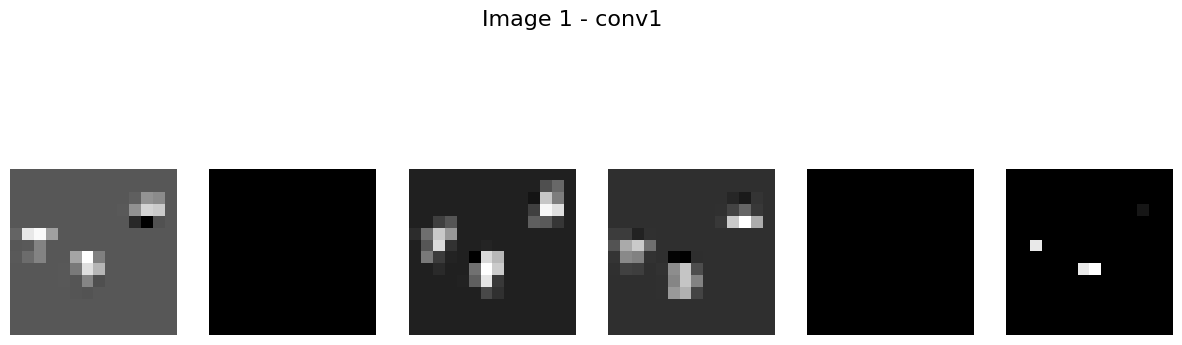

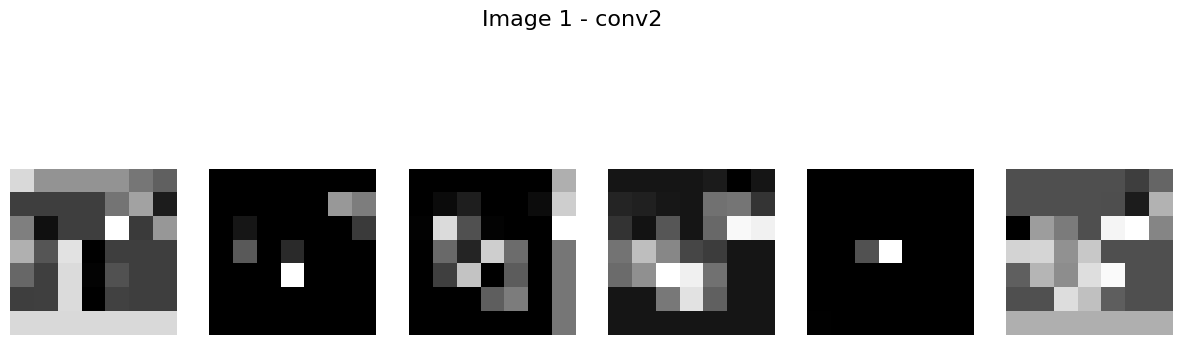

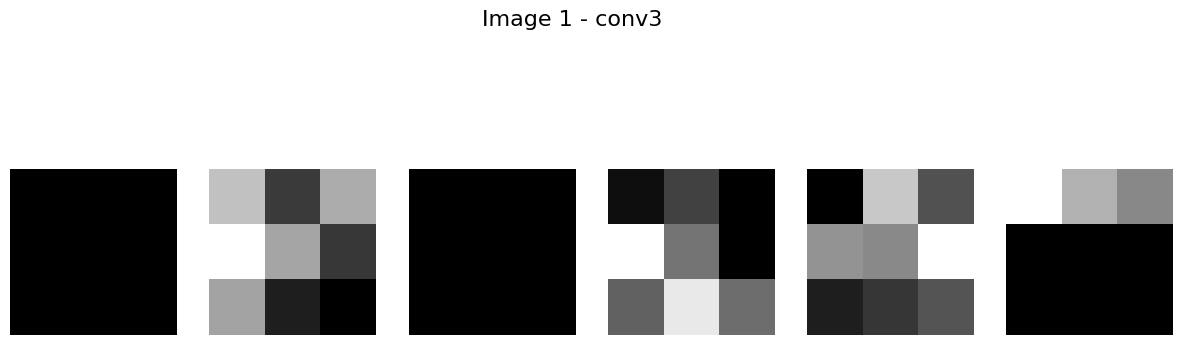

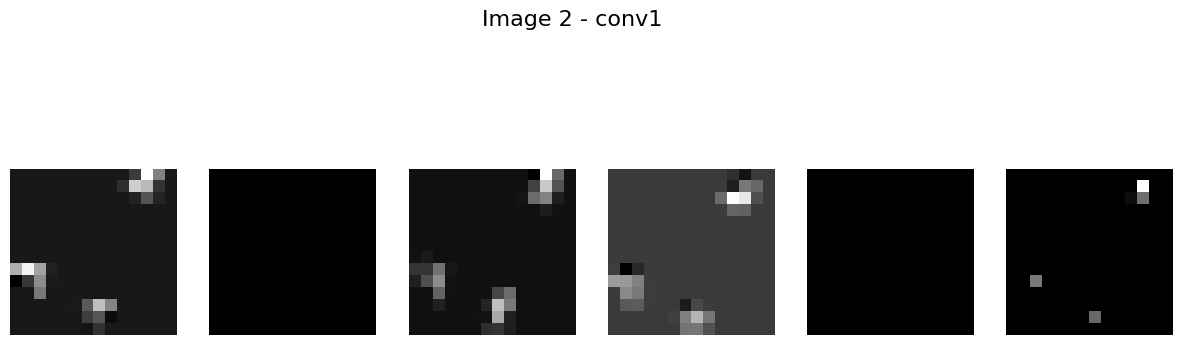

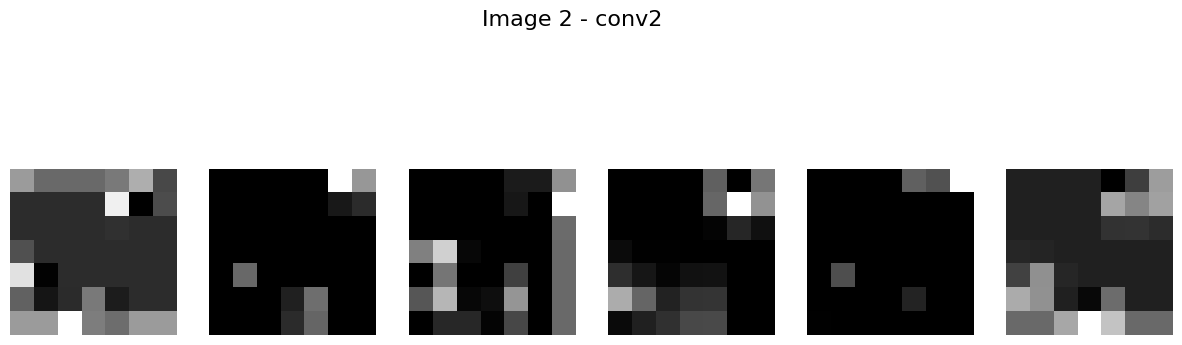

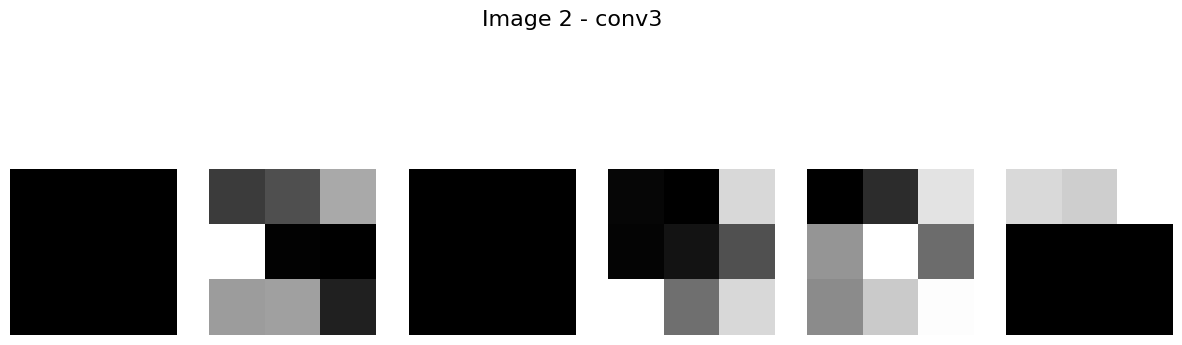

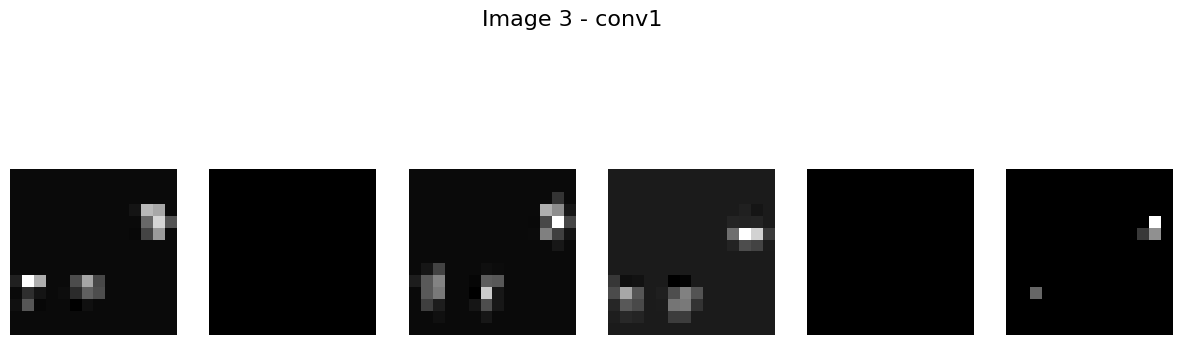

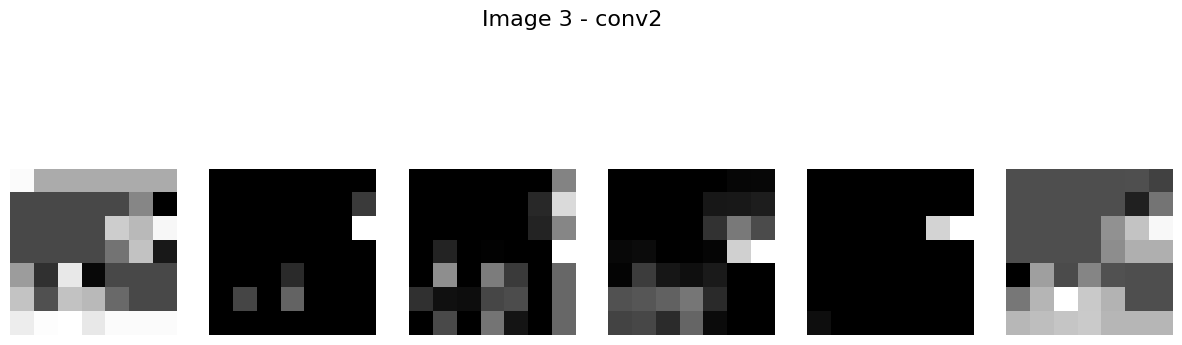

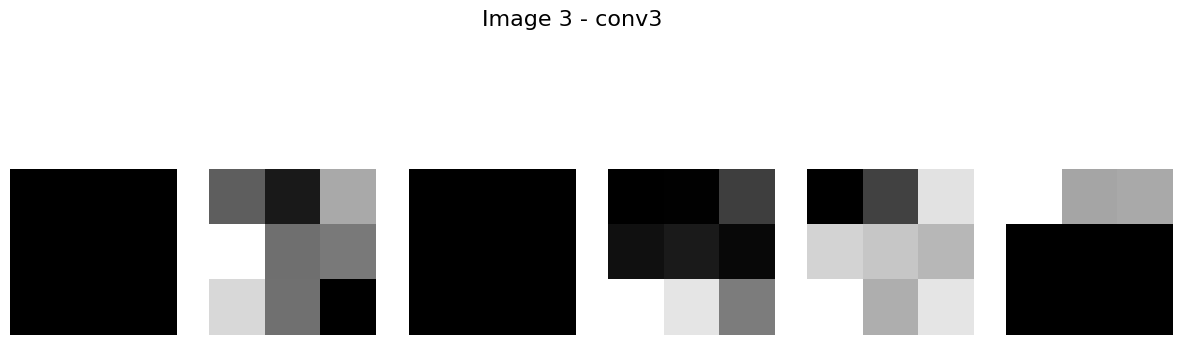

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Ensure the model runs on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNN(nn.Module):
    def __init__(self, task='classification'):
        super(CNN, self).__init__()
        self.task = task

        # Define convolutional layers and pooling
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Define fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 64)
        if self.task == "classification":
            self.fc2 = nn.Linear(64, 4)  # 4 classes for classification
        elif self.task == "regression":
            self.fc2 = nn.Linear(64, 1)  # 1 output for regression

    def forward(self, x, capture_feature_maps=False):
        # Initialize a dictionary to store intermediate feature maps
        feature_maps = {}

        # First convolutional block
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        if capture_feature_maps:
            feature_maps['conv1'] = x

        # Second convolutional block
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        if capture_feature_maps:
            feature_maps['conv2'] = x

        # Third convolutional block
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        if capture_feature_maps:
            feature_maps['conv3'] = x

        # Flatten the output for fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Return both the final output and the captured feature maps if requested
        return (x, feature_maps) if capture_feature_maps else x





# Function to visualize feature maps
def visualize_feature_maps(feature_maps, title="Feature Maps"):
    for layer_name, feature_map in feature_maps.items():
        fig, axes = plt.subplots(1, min(6, feature_map.shape[1]), figsize=(15, 5))
        fig.suptitle(f"{title} - {layer_name}", fontsize=16)

        for i in range(min(6, feature_map.shape[1])):  # Show up to 6 feature maps per layer
            axes[i].imshow(feature_map[0, i].cpu().detach().numpy(), cmap='gray')
            axes[i].axis('off')
        plt.show()

# Choose three images from the validation dataset
sample_images, _ = next(iter(val_loader))
sample_images = sample_images[:3]  # Select the first three images

# Instantiate the model and move it to the appropriate device
model_classification = CNN(task='classification').to(device)
model_classification.eval()

# Run each sample image through the model, capturing feature maps
with torch.no_grad():
    for i, image in enumerate(sample_images):
        image = image.unsqueeze(0).to(device)  # Add batch dimension
        output, feature_maps = model_classification(image, capture_feature_maps=True)

        # Visualize feature maps for each image
        visualize_feature_maps(feature_maps, title=f"Image {i+1}")





```
Conv1: Detects basic edges and textures.

Conv2: Captures more detailed shapes and patterns.

Conv3: Identifies abstract, high-level features for classification.

```

Epoch 1/7
Classification - Train Loss: 0.2580, Val Loss: 0.0042, Val Accuracy: 99.9667
Regression - Train Loss: 0.2199, Val Loss: 0.0171, Val Accuracy: 100.0000
Epoch 2/7
Classification - Train Loss: 0.0011, Val Loss: 0.0007, Val Accuracy: 100.0000
Regression - Train Loss: 0.0120, Val Loss: 0.0082, Val Accuracy: 100.0000
Epoch 3/7
Classification - Train Loss: 0.0003, Val Loss: 0.0002, Val Accuracy: 100.0000
Regression - Train Loss: 0.0078, Val Loss: 0.0059, Val Accuracy: 100.0000
Epoch 4/7
Classification - Train Loss: 0.0001, Val Loss: 0.0001, Val Accuracy: 100.0000
Regression - Train Loss: 0.0055, Val Loss: 0.0037, Val Accuracy: 100.0000
Epoch 5/7
Classification - Train Loss: 0.0000, Val Loss: 0.0001, Val Accuracy: 100.0000
Regression - Train Loss: 0.0048, Val Loss: 0.0032, Val Accuracy: 100.0000
Epoch 6/7
Classification - Train Loss: 0.0000, Val Loss: 0.0001, Val Accuracy: 100.0000
Regression - Train Loss: 0.0046, Val Loss: 0.0089, Val Accuracy: 100.0000
Epoch 7/7
Classification - Tr

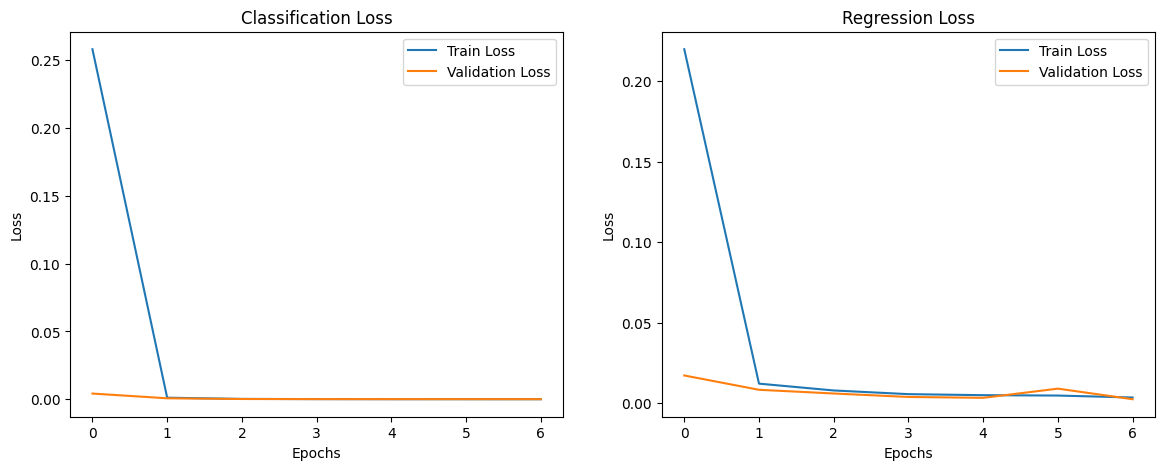

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Ensure the model runs on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNN(nn.Module):
    def __init__(self, task='classification'):
        super(CNN, self).__init__()
        self.task = task

        # Define convolutional layers and pooling
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Define fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 64)
        if self.task == "classification":
            self.fc2 = nn.Linear(64, 4)  # 4 classes for classification
        elif self.task == "regression":
            self.fc2 = nn.Linear(64, 1)  # 1 output for regression

    def forward(self, x, capture_feature_maps=False):

        # First convolutional block
        x = F.relu(self.conv1(x))
        x = self.pool(x)


        # Second convolutional block
        x = F.relu(self.conv2(x))
        x = self.pool(x)


        # Third convolutional block
        x = F.relu(self.conv3(x))
        x = self.pool(x)


        # Flatten the output for fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Return both the final output and the captured feature maps if requested
        return x







# Instantiate model for classification
model_classification = CNN(task='classification')
model_regression = CNN(task='regression')

# Loss function and optimizer for classification
criterion_classification = nn.CrossEntropyLoss()
optimizer_classification = optim.Adam(model_classification.parameters(), lr=0.001)



criterion_regression = nn.MSELoss()
optimizer_regression = optim.Adam(model_regression.parameters(), lr=0.001)


# Training function
def train(model, dataloader, criterion, optimizer, task='classification'):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        if task == 'classification':
            labels = labels.long()  # Convert labels to integer type for classification
            loss = criterion(outputs, labels)
        else:
            labels = labels.view(-1, 1).float()  # Ensure labels are [batch_size, 1] for regression
            loss = criterion(outputs, labels)
       # labels = labels.long()  # Convert labels to integer type for classification
        # loss = criterion(outputs, labels)
       # Backward pass and optimization
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

# Validation function
def validate(model, dataloader, criterion, task='classification'):
    model.eval()
    running_loss = 0.0
    correct = 0
    all_preds = []
    all_labels = []


    total_loss = 0
    correct_predictions = 0
    threshold = 0.6  # Define a threshold for considering a prediction as correct





    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)




            # labels = labels.long()
            # loss = criterion(outputs, labels)
            # _, predicted = torch.max(outputs, 1)
            # correct += (predicted == labels).sum().item()

            if task == 'classification':
                labels = labels.long()
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
            else:
                labels = labels.view(-1, 1).float()  # Ensure labels are [batch_size, 1] for regression
                loss = criterion(outputs, labels)
                all_preds.append(outputs.numpy())
                all_labels.append(labels.numpy())

                total_loss += criterion_regression(outputs, labels).item()  # Ensure labels have shape [batch_size, 1]


                # Count how many predictions are within the threshold
                correct_predictions += ((outputs - labels).abs() < threshold).sum().item()



            running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)


    if task == 'classification':
        accuracy = 100 * correct / len(dataloader.dataset)
    else:
        # Calculate average loss and accuracy-like metric for regression
        average_loss = total_loss / len(val_loader)
        accuracy = 100 * correct_predictions / len(val_loader.dataset)



    return epoch_loss, accuracy








# Training and validation loops
num_epochs = 7
train_losses_classification, val_losses_classification = [], []
train_losses_regression, val_losses_regression = [], []
val_acc_classification, val_acc_regression = [], []



for epoch in range(num_epochs):
    # Classification training and validation
    train_loss_class = train(model_classification, train_loader, criterion_classification, optimizer_classification)
    val_loss_class, val_acc_class = validate(model_classification, val_loader, criterion_classification)
    train_losses_classification.append(train_loss_class)
    val_losses_classification.append(val_loss_class)




    # Regression training and validation
    train_loss_reg = train(model_regression, train_loader, criterion_regression, optimizer_regression, task='regression')
    val_loss_reg, val_acc_reg = validate(model_regression, val_loader, criterion_regression, task='regression')
    train_losses_regression.append(train_loss_reg)
    val_losses_regression.append(val_loss_reg)
    # val_acc_regression.append(val_acc_reg)



    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Classification - Train Loss: {train_loss_class:.4f}, Val Loss: {val_loss_class:.4f}, Val Accuracy: {val_acc_class:.4f}")
    print(f"Regression - Train Loss: {train_loss_reg:.4f}, Val Loss: {val_loss_reg:.4f}, Val Accuracy: {val_acc_reg:.4f}")


# Plotting the losses and MAE (accuracy for regression)
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_classification, label='Train Loss')
plt.plot(val_losses_classification, label='Validation Loss')
plt.title("Classification Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses_regression, label='Train Loss')
plt.plot(val_losses_regression, label='Validation Loss')
plt.title("Regression Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


#### Train vs val loss for both classification and regression CNN

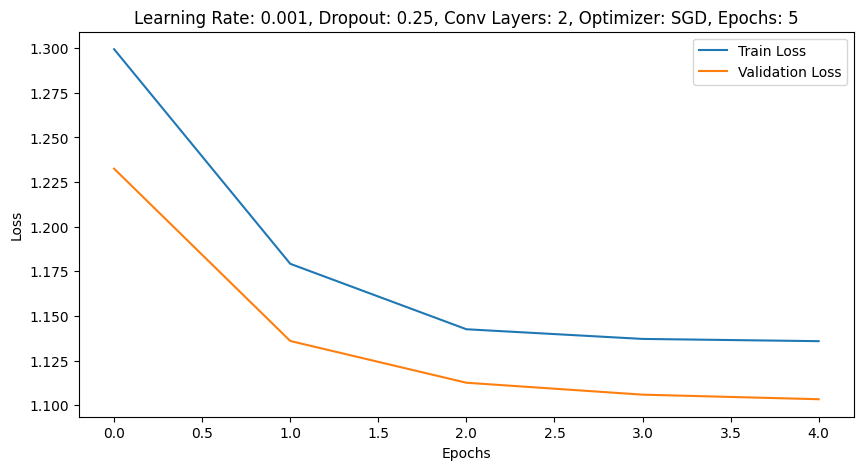

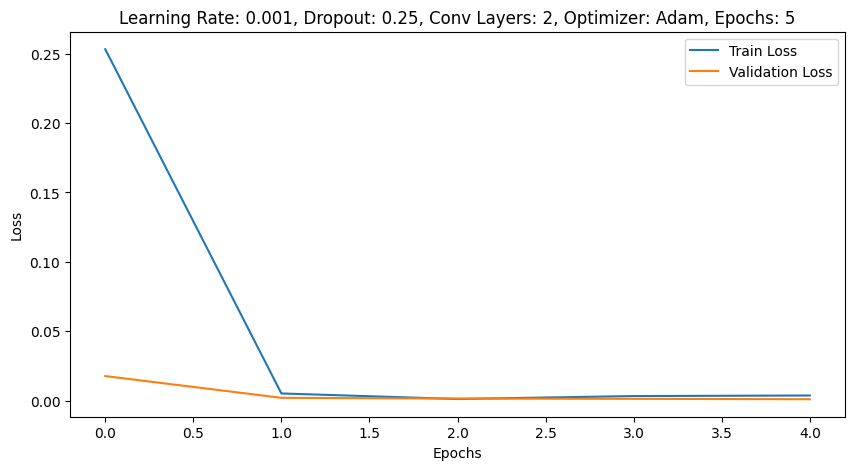

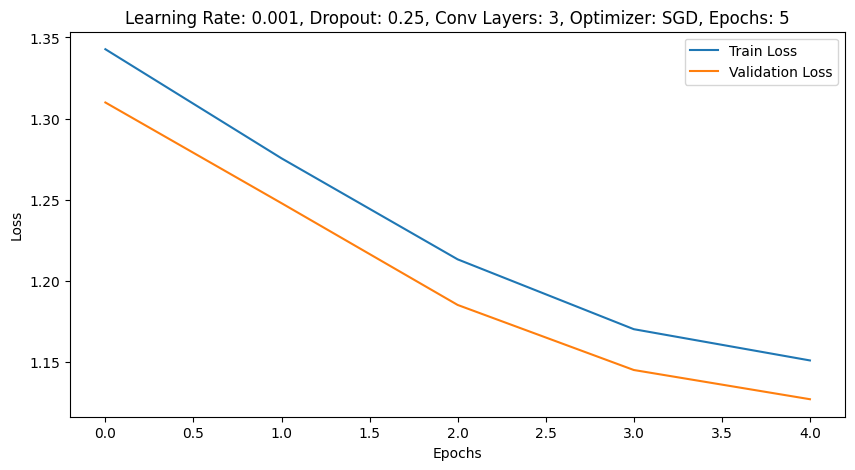

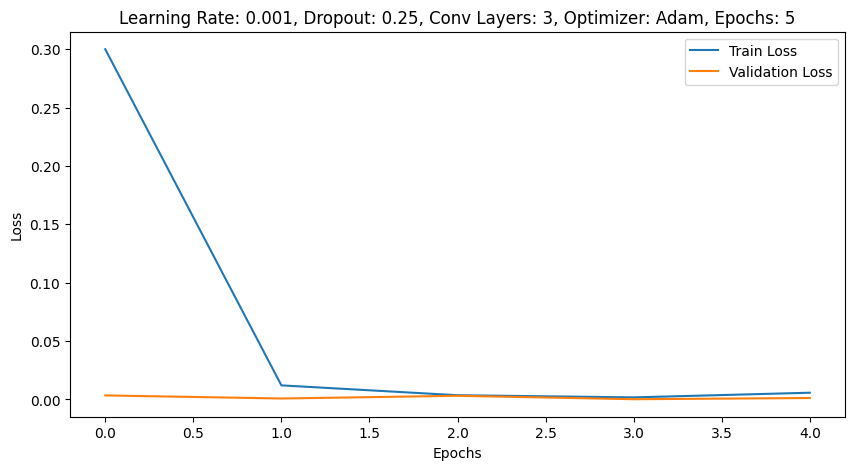

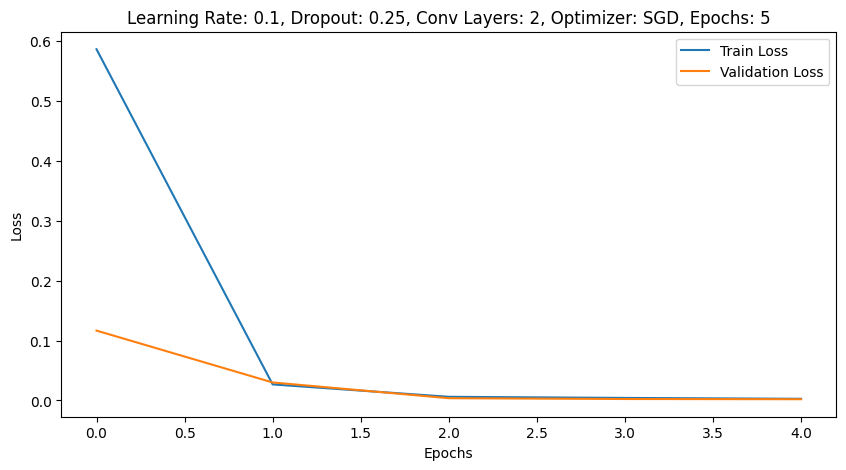

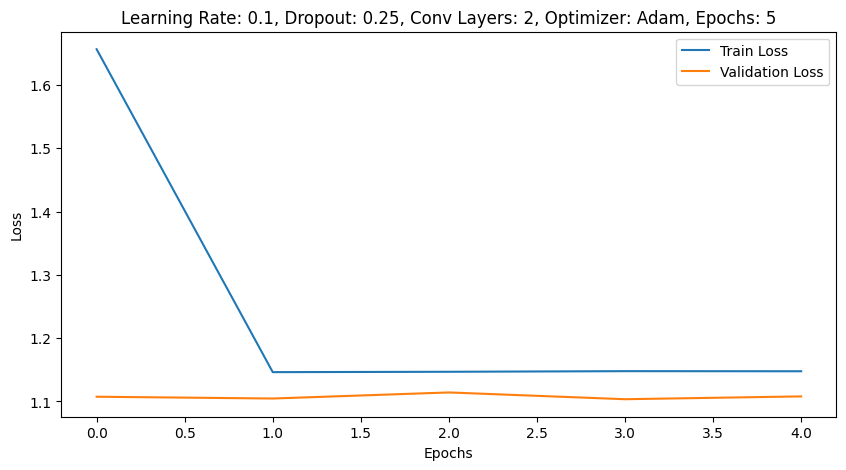

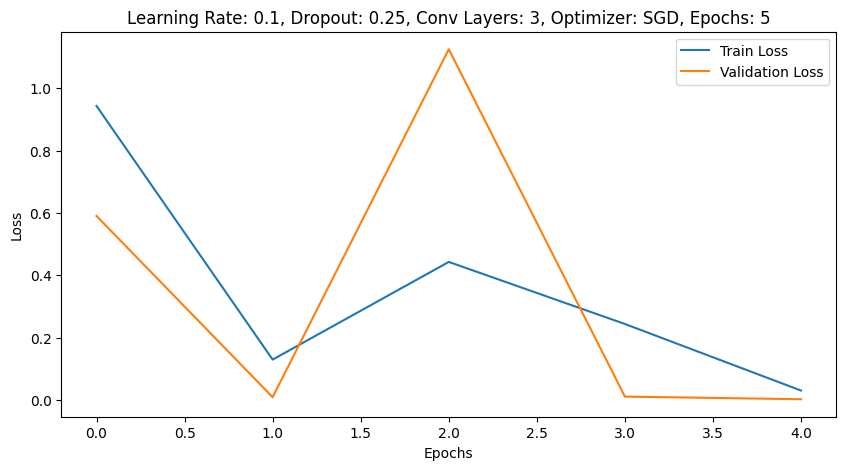

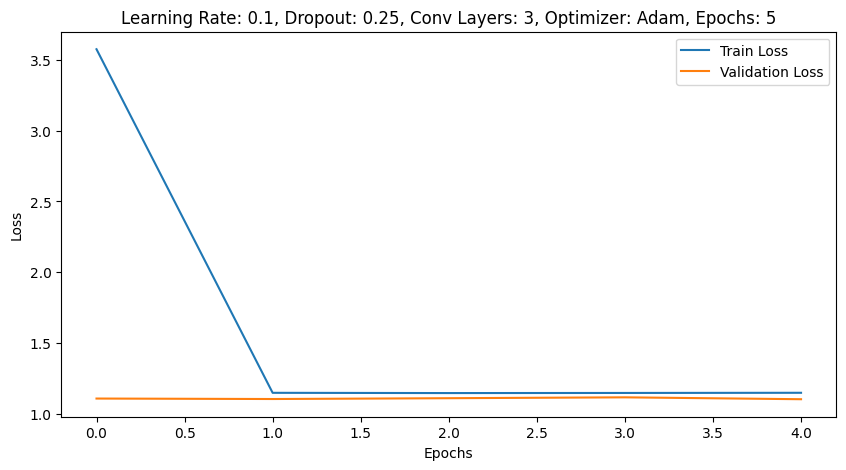

Best Hyperparameters:
Learning Rate: 0.001
Dropout Rate: 0.25
Number of Conv Layers: 2
Optimizer: Adam
Number of Epochs: 5
Best Validation Loss: 0.0010


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class CNN(nn.Module):
    def __init__(self, task='classification', num_conv_layers=3, dropout_rate=0.5):
        super(CNN, self).__init__()
        self.task = task

        # Define convolutional layers and pooling
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) if num_conv_layers > 2 else None
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        # Define fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3 if num_conv_layers > 2 else 64 * 7 * 7, 64)
        if self.task == "classification":
            self.fc2 = nn.Linear(64, 4)  # 4 classes for classification
        elif self.task == "regression":
            self.fc2 = nn.Linear(64, 1)  # 1 output for regression

    def forward(self, x, capture_feature_maps=False):
        # First convolutional block
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)

        # Second convolutional block
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)

        # Third convolutional block if applicable
        if self.conv3:
            x = F.relu(self.conv3(x))
            x = self.pool(x)
            x = self.dropout(x)

        # Flatten the output for fully connected layers
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


# Training function
def train(model, dataloader, criterion, optimizer, task='classification'):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        # Move data to the same device as the model
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        if task == 'classification':
            labels = labels.long()  # Convert labels to integer type for classification
        loss = criterion(outputs, labels)
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)


# Validation function
def validate(model, dataloader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Accuracy calculation for classification
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return val_loss / len(dataloader), correct / total


# Hyperparameters to tune
learning_rates = [0.001, 0.1]
dropout_rates = [0.25]
num_conv_layers_list = [2, 3]
optimizers_list = ['SGD', 'Adam']
num_epochs_list = [5]

# Track the best parameters and validation loss
best_params = {}
best_val_loss = float('inf')

# Instantiate data loaders (replace with actual train and validation loaders)
# train_loader = DataLoader(...)
# val_loader = DataLoader(...)

# Store losses for plotting
train_losses_classification, val_losses_classification = [], []

# Iterate through all combinations of hyperparameters
for lr in learning_rates:
    for dropout_rate in dropout_rates:
        for num_conv_layers in num_conv_layers_list:
            for optimizer_type in optimizers_list:
                for num_epochs in num_epochs_list:
                    # Instantiate the model with current hyperparameters
                    model_classification = CNN(task='classification', num_conv_layers=num_conv_layers, dropout_rate=dropout_rate).to(device)

                    # Set the optimizer
                    if optimizer_type == 'SGD':
                        optimizer = optim.SGD(model_classification.parameters(), lr=lr)
                    else:
                        optimizer = optim.Adam(model_classification.parameters(), lr=lr)

                    criterion = nn.CrossEntropyLoss()

                    # Reset losses for each hyperparameter combination
                    train_losses_classification, val_losses_classification = [], []

                    # Training loop for the current set of hyperparameters
                    for epoch in range(num_epochs):
                        train_loss = train(model_classification, train_loader, criterion, optimizer, task='classification')
                        val_loss, val_acc = validate(model_classification, val_loader, criterion)

                        train_losses_classification.append(train_loss)
                        val_losses_classification.append(val_loss)

                    # Check if the current validation loss is the best
                    if val_losses_classification[-1] < best_val_loss:
                        best_val_loss = val_losses_classification[-1]
                        best_params = {
                            'learning_rate': lr,
                            'dropout_rate': dropout_rate,
                            'num_conv_layers': num_conv_layers,
                            'optimizer': optimizer_type,
                            'num_epochs': num_epochs
                        }

                    # Plot training and validation loss
                    plt.figure(figsize=(10, 5))
                    plt.plot(train_losses_classification, label='Train Loss')
                    plt.plot(val_losses_classification, label='Validation Loss')
                    plt.xlabel("Epochs")
                    plt.ylabel("Loss")
                    plt.title(f"Learning Rate: {lr}, Dropout: {dropout_rate}, Conv Layers: {num_conv_layers}, Optimizer: {optimizer_type}, Epochs: {num_epochs}")
                    plt.legend()
                    plt.show()

# Print the best hyperparameters
print("Best Hyperparameters:")
print(f"Learning Rate: {best_params['learning_rate']}")
print(f"Dropout Rate: {best_params['dropout_rate']}")
print(f"Number of Conv Layers: {best_params['num_conv_layers']}")
print(f"Optimizer: {best_params['optimizer']}")
print(f"Number of Epochs: {best_params['num_epochs']}")
print(f"Best Validation Loss: {best_val_loss:.4f}")


### Hyperparameters I used
```
learning_rates = [0.001, 0.1]
dropout_rates = [0.25]
num_conv_layers_list = [2, 3]
optimizers_list = ['SGD', 'Adam']
num_epochs_list = [5,10]
```

### Best Hyperparameters got:
```
Learning Rate: 0.001
Dropout Rate: 0.25
Number of Conv Layers: 2
Optimizer: Adam
Number of Epochs: 5
Best Validation Loss: 0.0010
```


```
Classification - Train Loss: 0.0000, Val Loss: 0.0001, Val Accuracy: 100.0000
Regression - Train Loss: 0.0046, Val Loss: 0.0089, Val Accuracy: 100.0000

```

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

unzip_dir = ''
# List the contents of the extracted 'double_mnist' folder
os.listdir(os.path.join(unzip_dir, 'double_mnist'))


['val', '.ipynb_checkpoints', 'test', 'train']

In [14]:
# Replace with the path to one of your images
image_path = os.path.join(unzip_dir, 'double_mnist', 'train', '004', '3_004.png')  # Adjust this path

# Load the image
image = Image.open(image_path)

# Get the original size
original_size = image.size  # Returns (width, height)
print("Original image size:", original_size)

Original image size: (128, 128)


In [15]:
class MultiMNISTDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_digits=3):
        """
        Custom Dataset for loading MultiMNIST images for the given task.
        root_dir: Directory with subfolders containing images.
        transform: Transformations to be applied to the images.
        max_digits: Maximum number of digits expected in any label.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.max_digits = max_digits

        # Iterate over subfolders (each subfolder name is a sequence of digits, e.g., "123")
        for subfolder in os.listdir(root_dir):
            subfolder_path = os.path.join(root_dir, subfolder)
            if os.path.isdir(subfolder_path):
                # Extract individual digits from subfolder name and create multi-label vector
                label = [int(digit) for digit in subfolder]
                for img_name in os.listdir(subfolder_path):
                    img_path = os.path.join(subfolder_path, img_name)
                    self.images.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('L')  # Load image in grayscale
        label = self.labels[idx]

        # Apply transformations to the image if defined
        if self.transform:
            image = self.transform(image)

        # Convert label to one-hot encoding (0-9 for each digit) and pad if needed
        one_hot_label = torch.zeros(10 * self.max_digits)  # Initialize a tensor of zeros of size 30
        for i, digit in enumerate(label[:self.max_digits]):  # Use only up to max_digits
            one_hot_label[i * 10 + digit] = 1  # One-hot encode each digit position

        return image, one_hot_label






# Update load_mnist_data function to use DataLoader
def load_mnist_data(root_dir):
    """
    Loads images and labels from the dataset folders (train, val, test).
    Returns DataLoader objects for train, validation, and test sets.
    """
    transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

    train_dataset = MultiMNISTDataset(os.path.join(root_dir, 'train'), transform=transform, max_digits=3)
    val_dataset = MultiMNISTDataset(os.path.join(root_dir, 'val'), transform=transform, max_digits=3)
    test_dataset = MultiMNISTDataset(os.path.join(root_dir, 'test'), transform=transform, max_digits=3)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, val_loader, test_loader

# Load the datasets for training, validation, and testing
train_loader, val_loader, test_loader = load_mnist_data(os.path.join(unzip_dir, 'double_mnist'))


Batch of images shape: torch.Size([32, 1, 64, 64])
Batch of labels shape: torch.Size([32, 30])
Sample label in numeric form: [1, 1, 7]


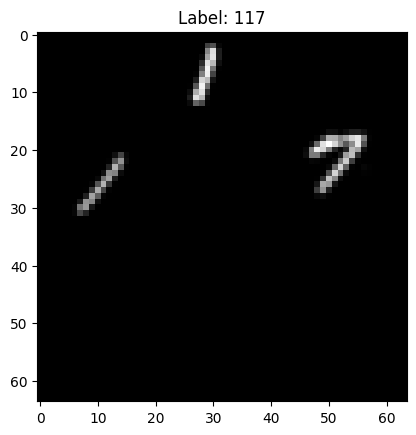

In [16]:
# Check a single batch from the train loader
for images, labels in train_loader:
    print("Batch of images shape:", images.shape)   # Should be [batch_size, channels, height, width]
    print("Batch of labels shape:", labels.shape)   # Should be [batch_size, num_classes]

    # Display a sample image and its label in numeric form
    sample_image = images[0]
    sample_label = labels[0]

    # Decode one-hot encoding to label numbers
    numeric_label = []
    for i in range(3):  # Loop through each position (3 digits max)
        digit = torch.argmax(sample_label[i*10:(i+1)*10]).item()
        numeric_label.append(digit)

    print("Sample label in numeric form:", numeric_label)

    # Display the image
    import matplotlib.pyplot as plt
    plt.imshow(sample_image.squeeze(), cmap='gray')
    plt.title(f"Label: {''.join(map(str, numeric_label))}")  # Show label as a single string
    plt.show()
    break  # Only check the first batch


Predicted Labels: [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 4, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 4, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 5, 0], [0, 0, 0], [0, 0, 0], [0, 5, 0], [0, 0, 0]]
Actual Labels:  [[7, 9, 6], [7, 9, 6], [7, 9, 6], [7, 9, 6], [7, 9, 6], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0], [6, 4, 0]]
0
888
960
0
Predicted Labels: [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]

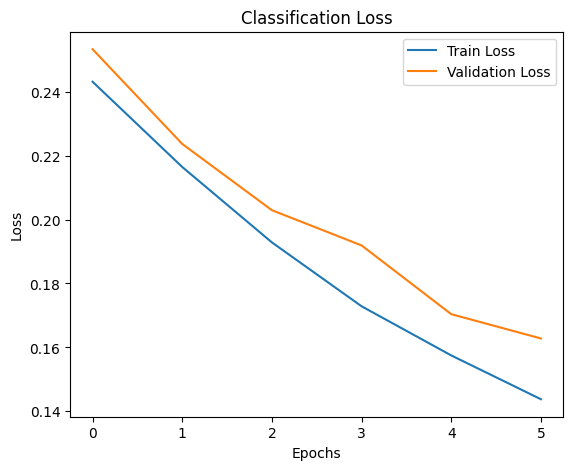

In [18]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torch.nn as nn
import torch.nn.functional as F

class MultiLabelCNN(nn.Module):
    def __init__(self):
        super(MultiLabelCNN, self).__init__()

        # Define convolutional layers with increasing feature maps
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input channels=1 for grayscale
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)  # 2x2 max pooling
        self.dropout = nn.Dropout(0.25)  # Dropout layer




        #         # Flatten layer
        self.flatten = nn.Flatten()



        # Flatten layer before the fully connected layer
        self.fc1 = nn.Linear(128 * 8 * 8, 128)  # Output of conv2 after pooling for 64x64 input
        # self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Output of conv2 after pooling is 7x7 for 28x28 input
        # self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Output of conv2 after pooling for 128x128 input

        self.fc2 = nn.Linear(128, 10 * 3)  # Assuming a max sequence length of 5 digits, each with 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)  # Conv layer 1 + ReLU + Pooling
        x = self.pool(F.relu(self.conv2(x)))  # Conv layer 2 + ReLU + Pooling
        x = self.dropout(x)


        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = self.dropout(x)

         # Apply dropout to reduce overfitting
        # x = x.view(-1, 64 * 7 * 7)  # Flatten the tensor for fully connected layer
        # Flatten before passing to fully connected layers
        x = self.flatten(x)


        x = F.relu(self.fc1(x))  # Fully connected layer + ReLU
        # x = self.fc2(x)  # Output layer
        # x = torch.sigmoid(x)  # Sigmoid activation for multi-label output probabilities
        x = self.dropout(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)


      # Reshape output to (batch_size, num_digits, num_classes)
        x = x.view(-1, 3*10)


        return x



# Initialize model, criterion, optimizer
model = MultiLabelCNN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.float()  # Convert labels to float type for BCELoss
        labels = labels.view_as(outputs)  # Ensure labels have the same shape as outputs

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()* inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss







# Validation function
def validate(model, dataloader, criterion):
    model.eval()
    exact_matches = 0
    running_loss = 0.0
    correct = 0
    total_samples = 0
    c = 0
    threshold = 0.6  # Define a threshold for considering a prediction as correct

    with torch.no_grad():
        for images, labels in dataloader:
            outputs = model(images)
            # labels = labels.long()
            # loss = criterion(outputs, labels)
            # _, predicted = torch.max(outputs, 1)
            # correct += (predicted == labels).sum().item()
            labels = labels.float()
            loss = criterion(outputs, labels)
            # Convert outputs to binary predictions
            # Count total number of outputs
            c += outputs.numel()
            preds = (outputs > 0.3).float()  # Threshold outputs for multi-label binary classification

            correct += (preds == labels).sum().item()  # Count correct predictions

            # Decode predicted labels
            predicted_labels = []
            for pred in preds:
                numeric_label = [int(torch.argmax(pred[i*10:(i+1)*10]).item()) for i in range(3)]  # Adjust based on max_digits
                predicted_labels.append(numeric_label)

            # Decode actual labels
            actual_labels = []
            for label in labels:
                numeric_label = [int(torch.argmax(label[i*10:(i+1)*10]).item()) for i in range(3)]  # Adjust based on max_digits
                actual_labels.append(numeric_label)

            print("Predicted Labels:", predicted_labels)
            print("Actual Labels: ", actual_labels)
            print(total_samples)
            print(correct)
            print(c)




                        # Exact match accuracy: all labels must match for a sample to be counted as correct
            exact_matches += (preds == labels).all(dim=1).sum().item()
            print(exact_matches)
            total_samples += labels.size(0)



            # total_samples += labels.numel()  # Total number of labels
            running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = 100 * correct / 90000  # Calculate accuracy based on total labels
    exact_match_accuracy = 100 * exact_matches / total_samples


    return epoch_loss, accuracy, exact_match_accuracy
# Training and validation loops
num_epochs = 6
train_losses_classification, val_losses_classification = [], []
exact_val_acc = []
val_acc_classification = []



for epoch in range(num_epochs):
    # Classification training and validation
    train_loss_class = train(model, train_loader, criterion, optimizer)
    val_loss_class, val_acc_class, exact_val_acc = validate(model, val_loader, criterion)
    train_losses_classification.append(train_loss_class)
    val_losses_classification.append(val_loss_class)





    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Classification - Train Loss: {train_loss_class:.4f}, Val Loss: {val_loss_class:.4f}, Hamming Accuracy: {val_acc_class:.4f}, exact_val_acc = {exact_val_acc:.4f}")


plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_classification, label='Train Loss')
plt.plot(val_losses_classification, label='Validation Loss')
plt.title("Classification Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()



plt.show()













#### getting: 
```
Classification - 

Train Loss: 0.1438,
 Val Loss: 0.1628,
Hamming Accuracy: 92.6922,
exact_val_acc = 10.4000
```